In [23]:
from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym

env = gym.make("CartPole-v1")

In [24]:
done = False
observation, info = env.reset()
action = env.action_space.sample()
observation, reward, terminated, truncated, info = env.step(action)
print(observation)
print(reward)
print(terminated)
print(truncated)
print(info)

[ 0.02618297  0.15755521  0.03576742 -0.2407466 ]
1.0
False
False
{}


In [25]:
#explorar los valores para armar bins
print(env.observation_space.low)
print(env.observation_space.high)
print(env.action_space.n)

#definir los bins
pos_space = np.linspace(-2.4, 2.4, 10) #episode ends if cart leaves -2.4 < x < 2.4
vel_space = np.linspace(-3, 3, 10)
ang_space = np.linspace(-0.2, 0.2, 10) #episode ends if pole falls beyond this angle
tip_vel_space = np.linspace(-3, 3, 10)

# los bins infinitos los hice con el exp anterior pa ver max y min, de ultima desp ajusto

[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
2


In [26]:
def get_state(obs):
    pos, vel, ang, tip_vel = obs
    pos_bin = np.digitize(pos, pos_space)
    vel_bin = np.digitize(vel, vel_space)
    ang_bin = np.digitize(ang, ang_space)
    tip_vel_bin = np.digitize(tip_vel, tip_vel_space)
    return pos_bin, vel_bin, ang_bin, tip_vel_bin


In [27]:


actions = list(range(env.action_space.n))
Q = np.zeros((len(pos_space)+1, len(vel_space)+1, len(ang_space)+1, len(tip_vel_space)+1, len(actions)))

def optimal_policy(state, Q):
    action = np.argmax(Q[state])
    return action


In [28]:
class CartPoleAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        self.lr = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.training_error = []
        self.actions = list(range(env.action_space.n))
        self.Q = np.zeros(
            (len(pos_space) + 1, len(vel_space) + 1, len(ang_space) + 1, len(tip_vel_space) + 1, len(self.actions))
        )

    def get_state(self, obs):
        pos, vel, ang, tip_vel = obs
        pos_bin = np.digitize(pos, pos_space)
        vel_bin = np.digitize(vel, vel_space)
        ang_bin = np.digitize(ang, ang_space)
        tip_vel_bin = np.digitize(tip_vel, tip_vel_space)
        return pos_bin, vel_bin, ang_bin, tip_vel_bin

    def get_action(self, obs):
        state = self.get_state(obs)
        if np.random.random() < self.epsilon:
            return np.random.choice(self.actions)
        else:
            return int(np.argmax(self.Q[state]))

    def update(self, obs, action, reward, terminated, next_obs):
        state = self.get_state(obs)
        next_state = self.get_state(next_obs)
        future_q_value = (not terminated) * np.max(self.Q[next_state])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.Q[state][action]
        )
        self.Q[state][action] += self.lr * temporal_difference
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)


In [29]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = CartPoleAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [30]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 100000/100000 [07:35<00:00, 219.63it/s]


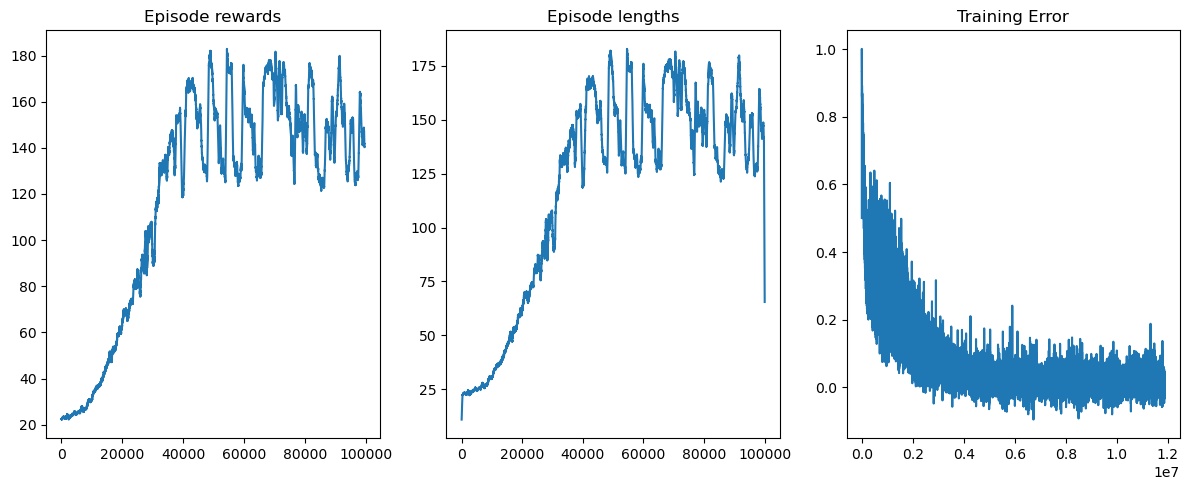

In [31]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()